In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
%matplotlib inline

In [4]:
from IPython.display import display, Audio
import matplotlib.patches as mpat
from matplotlib.offsetbox import AnchoredText
import scipy.ndimage

# Chroma deep-dive

Based on the [enhanced chroma](https://librosa.github.io/librosa/auto_examples/plot_chroma.html#sphx-glr-auto-examples-plot-chroma-py) example in the librosa documentation.

## Chroma = spectrogram + octave folding

But what can go wrong?

- Tuning
- Transients
- Other noise

## Running example

In [5]:
# Blue Highway by Podington Bear
# http://freemusicarchive.org/music/Podington_Bear/Soul/Blue_Highway
y, sr = librosa.load('Podington_Bear_-_Blue_Highway.mp3',
                     offset=53, duration=30)

In [6]:
display(Audio(data=y, rate=sr), transient=True)

## CQT and basic chroma

In [7]:
C = librosa.cqt(y=y, sr=sr)
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

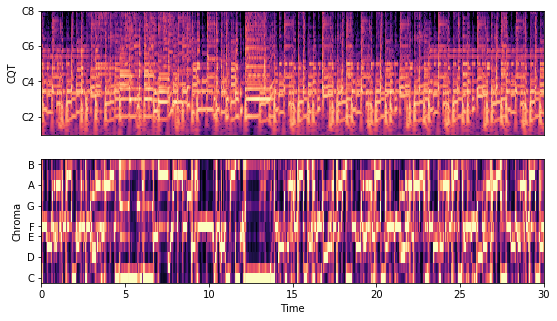

In [25]:
plt.figure(figsize=(9, 5))
ax = plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max),
                         y_axis='cqt_note', x_axis='time', rasterized=True)
plt.gca().xaxis.set_visible(False)
plt.ylabel('CQT')
plt.subplot(2,1,2, sharex=ax)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma')
display(Audio(data=y, rate=sr), transient=True)

## Why does this look so messy?

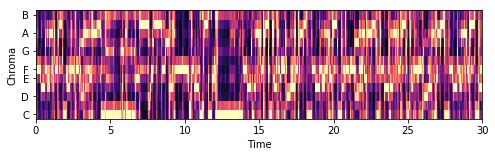

In [9]:
plt.figure(figsize=(8, 2))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma');

- Poor frequency resolution
- Glissando, vibrato
- Transients

### Increase frequency resolution

In [67]:
BPO = 12 * 3
chroma_2 = librosa.feature.chroma_cqt(y=y, sr=sr,
                                      bins_per_octave=BPO)

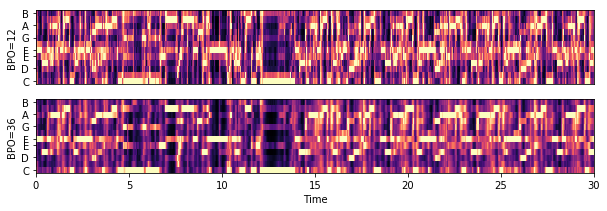

In [68]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(2,1,1)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', rasterized=True)
plt.ylabel('BPO=12')
plt.gca().xaxis.set_visible(False)
plt.subplot(2,1,2, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_2, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('BPO={}'.format(BPO));

## Dealing with transients

Harmonic-Percussive source separation (HPSS)


- General idea: decompose the spectrum into $S = S_H + S_P$

- $S_H$ is sustained tones

- $S_P$ is percussion

(Other noise can be dealt with later...)

## HPSS [(Fitzgerald, 2010)](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1078&context=argcon)

For each bin $S[t, f]$, calculate the median energy of:  
- $S[f, t']\quad(t' \in t \pm w_t)\quad\leftarrow$ time neighbors 
- $S[f', t]\quad(f' \in f \pm w_f)\;\;\leftarrow$ frequency neighbors

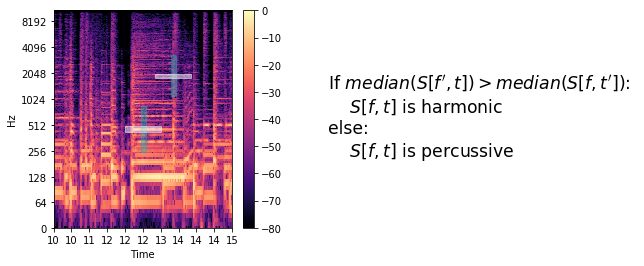

In [54]:
S = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(4,4))
ax = plt.gca()
librosa.display.specshow(S, x_axis='time', y_axis='log', rasterized=True)
ax.add_patch(mpat.Rectangle((12.45, 250), 0.125, 600, alpha=0.4, color='c', label='Percussive filter'))
ax.add_patch(mpat.Rectangle((12, 430), 1.0, 64, alpha=0.5, color='w', label='Harmonic filter'))
ax.add_patch(mpat.Rectangle((13.3, 1100), 0.125, 2200, alpha=0.4, color='c', label='Percussive filter'))
ax.add_patch(mpat.Rectangle((12.85, 1800), 1.0, 192, alpha=0.5, color='w', label='Harmonic filter'))
desc = AnchoredText('''If $median(S[f', t]) > median(S[f, t'])$:\n'''
                    '''    $S[f, t]$ is harmonic\n'''
                    '''else:\n'''
                    '''    $S[f, t]$ is percussive\n''',
                    loc=2, frameon=False,
                    bbox_to_anchor=(1.5, .75),
                    bbox_transform=ax.transAxes,
                    borderpad=0.0, prop=dict(size='xx-large'))
ax.add_artist(desc)
ax.set_xlim([10, 15]);
plt.colorbar();

### How does it look?

In [113]:
y_harm, y_perc = librosa.effects.hpss(y, margin=8)
Charm = librosa.cqt(y=y_harm, sr=sr)
Cperc = librosa.cqt(y=y_perc, sr=sr)

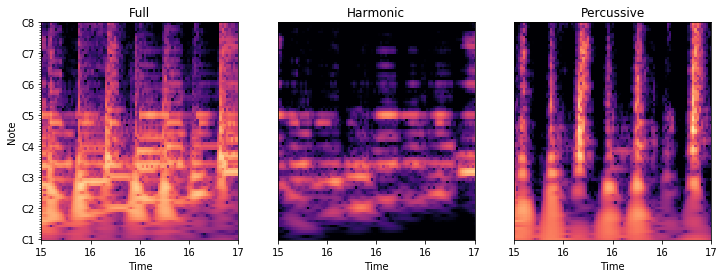

In [114]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max),
                         y_axis='cqt_note', x_axis='time', rasterized=True)
plt.title('Full')
plt.subplot(1,3,2, sharex=ax, sharey=ax)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Charm), ref=np.max),
                         y_axis='cqt_note', x_axis='time', rasterized=True)
plt.title('Harmonic')
plt.gca().yaxis.set_visible(False)
plt.subplot(1,3,3, sharex=ax, sharey=ax)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Cperc), ref=np.max),
                         y_axis='cqt_note', x_axis='time', rasterized=True)
plt.title('Percussive')
plt.gca().yaxis.set_visible(False)
plt.xlim([15, 17]);

display(Audio(data=y, rate=sr), transient=True)
display(Audio(data=y_harm, rate=sr), transient=True)
display(Audio(data=y_perc, rate=sr), transient=True)

### Back to chroma

Using only the harmonic component `y_harm`:

In [75]:
chroma_3 = librosa.feature.chroma_cqt(y=y_harm, sr=sr,
                                      bins_per_octave=BPO)

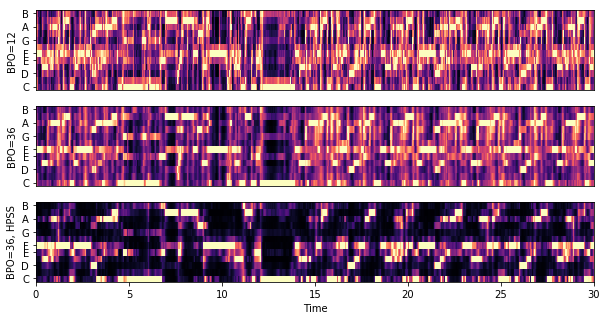

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(3,1,1)
librosa.display.specshow(chroma, y_axis='chroma', rasterized=True)
plt.ylabel('BPO=12')
plt.gca().xaxis.set_visible(False)
plt.subplot(3,1,2)
librosa.display.specshow(chroma_2, y_axis='chroma', rasterized=True);
plt.ylabel('BPO={}'.format(BPO))
plt.gca().xaxis.set_visible(False)
plt.subplot(3,1,3)
librosa.display.specshow(chroma_3, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('BPO={}, HPSS'.format(BPO));

## What about non-transient noise?

- Random pitched noise
- Passing notes
- Background noise

We can smooth these out by using **local** or **non-local filtering**

## Local filtering

- Smooth each coordinate across time to eliminate sparse noise
- Linear filtering introduces blur
- Non-linear filtering (`median`) preserves boundaries

In [83]:
# Linear box filter
W = 9
chroma_mean = scipy.ndimage.convolve1d(chroma_3, np.ones(W)/W,
                                       axis=1)
# Median filter
chroma_med = scipy.ndimage.median_filter(chroma_3, size=(1, W))

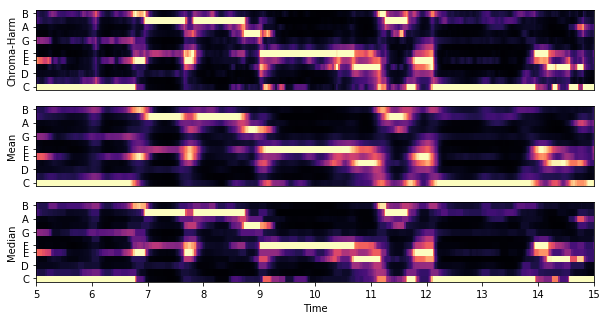

In [84]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(3,1,1)
librosa.display.specshow(chroma_3, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-Harm')
plt.gca().xaxis.set_visible(False)
plt.subplot(3,1,2, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_mean, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Mean')
plt.gca().xaxis.set_visible(False)
plt.subplot(3,1,3, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_med, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Median')
plt.xlim([5, 15]);

## Non-local means
#### [(Cho, 2014)](http://marl.smusic.nyu.edu/papers/cho_dissertation_nyu.pdf), and many others

- Replace frame `t` by an aggregate of its neighbors
- Neighbors in **feature space** (similar chroma), not in time
- Implemented by `librosa.decompose.nn_filter`

## Using nlmeans

In [100]:
rec = librosa.segment.recurrence_matrix(chroma_med, metric='cityblock',
                                        mode='affinity')

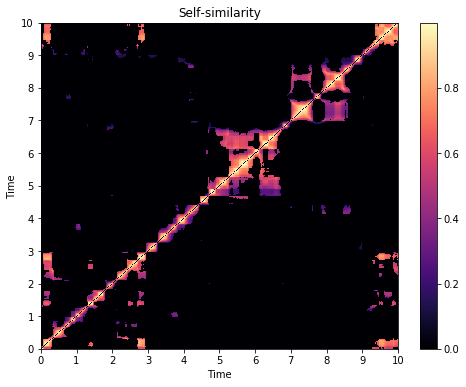

In [101]:
plt.figure(figsize=(8, 6))
librosa.display.specshow(rec, x_axis='time', y_axis='time', rasterized=True);
plt.title('Self-similarity');
plt.colorbar();
plt.xlim([0, 10]), plt.ylim([0, 10]);

In [111]:
# We could also use a pre-computed recurrence matrix
chroma_4 = librosa.decompose.nn_filter(chroma_3, aggregate=np.median,
                                       metric='cityblock')

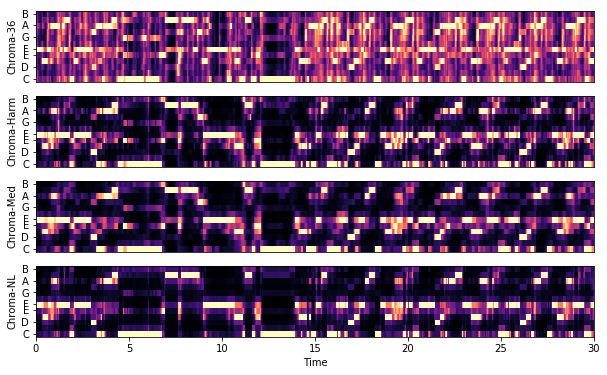

In [112]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(4,1,1)
librosa.display.specshow(chroma_2, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-36')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,2, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_3, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-Harm')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,3, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_med, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-Med')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,4, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_4, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-NL');
#plt.xlim([5, 15]);

## CENS
#### ([Mueller et al., 2005](https://ieeexplore.ieee.org/abstract/document/1540223/)) 

**C**hroma **E**nergy-distribution **N**ormalised **S**tatistics:

1. Apply a non-linear warping of energies by quantization
2. Smooth features in time

Why?

- Boost quieter notes
- Reduce influence of loudest note

### CENS quantization

1. Normalize each frame to sum to 1 (energy distribution)
2. Non-linear quantization:
    - `c <  0.05` => 0
    - `c <  0.10` => 1
    - `c <  0.20` => 2
    - `c <  0.40` => 3
    - `c >= 0.40` => 4
3. Renormalize (euclidean norm)

In [23]:
# First without smoothing
cens_harm = librosa.feature.chroma_cens(y=y_harm,  bins_per_octave=BPO,
                                        win_len_smooth=1)
# Then with (Hann) smoothing
W=9
cens_harm_2 = librosa.feature.chroma_cens(y=y_harm, bins_per_octave=BPO,
                                          win_len_smooth=W)

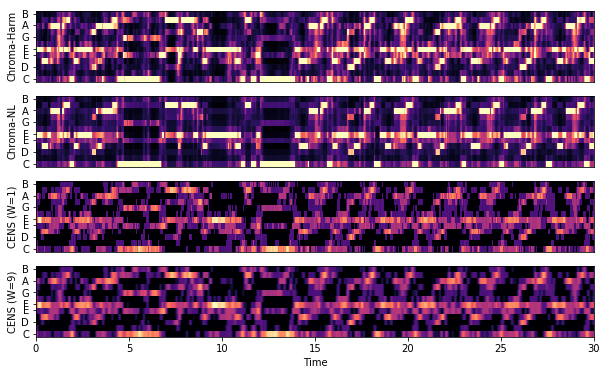

In [33]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(4,1,1)
librosa.display.specshow(chroma_3, y_axis='chroma', x_axis='time', rasterized=True)
plt.ylabel('Chroma-Harm')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,2, sharex=ax, sharey=ax)
librosa.display.specshow(chroma_4, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('Chroma-NL')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,3, sharex=ax, sharey=ax)
librosa.display.specshow(cens_harm, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('CENS (W=1)')
plt.gca().xaxis.set_visible(False)
plt.subplot(4,1,4, sharex=ax, sharey=ax)
librosa.display.specshow(cens_harm_2, y_axis='chroma', x_axis='time', rasterized=True);
plt.ylabel('CENS (W={})'.format(W));
#plt.xlim([5, 25]);

## Advanced chroma recap

When should you use these methods?

- High frequency res usually helps
- HPSS usually helps
- CENS suppresses noise and boosts quiet notes
- NL-means can fail in harmonically complex music
- Do you care about stable harmony or decorations?